In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt

from string import ascii_lowercase
import requests

In [2]:
# get list of words
words = requests.get(
    "https://raw.githubusercontent.com/karpathy/makemore/master/names.txt"
    ).text.splitlines()
print(f'{len(words)=}')
print(f'{words[:5]=}')

len(words)=32033
words[:5]=['emma', 'olivia', 'ava', 'isabella', 'sophia']


In [3]:
# integer mappings of characters
chars = ascii_lowercase
stoi = {s:i+1 for i, s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s, i in stoi.items()}

In [4]:
# number of characters including '.'
char_total = 27
# number of previous characters to consider for prediction
block_size = 3
# chosen dimensionality of characters
char_dim = 2

In [5]:
# build the dataset

X, Y = [], []
for w in words[:5]:
  
  #print(w)
  context = [0] * block_size
  for ch in w + '.':
    ix = stoi[ch]
    X.append(context)
    Y.append(ix)
    #print(''.join(itos[i] for i in context), '--->', itos[ix])
    context = context[1:] + [ix] # crop and append
  
X = torch.tensor(X)
Y = torch.tensor(Y)

In [106]:
# each of char_total characters will have a char_dim-dimensional embedding
C = torch.randn(char_total, char_dim)

In [7]:
# retrieve char_dim-dimensional vectors for every char_total character embedding in X
emb = C[X]

In [8]:
print(f'{C.shape=}')
print(f'{X.shape=}')
print(f'{emb.shape=}')

C.shape=torch.Size([27, 2])
X.shape=torch.Size([32, 3])
emb.shape=torch.Size([32, 3, 2])


In [9]:
# number of neurons in each layer
layer1_size = 100

In [10]:
# weights & biases of first layer
# weights are block_size * char_dim
# biases are scalars
W1 = torch.randn((block_size*char_dim, layer1_size))
b1 = torch.randn(layer1_size)

We want to perform `emb @ W1 + b1`, but we cannot matrix multiply `[228146, 3, 4]` by `[6, 100]`. We need a way to concatenate the embedding into a smaller space.

The theory is to break out each character in block_size, like `[emb[:, 0, :], emb[:, 1, :] ..., emb[:, n, :]`. The `torch.unbind()` function works here, but `<tensor>.view()` works even better.

(`.view()` works even better because it just manipulates the "view" of the underlying storage of the tensor, which is just all the numbers in the tensor. concatenate & unbind create an entirely new tensor, which requires a lot of new memory.)

In [11]:
# unbind embedding at the embedding's block_size dimension
# 2nd dimension (block size of 3) indexed at 1

# compare .view() to unbind & concat
torch.all(emb.view(emb.shape[0], emb.shape[1]*emb.shape[2]) == torch.cat(torch.unbind(emb, 1), 1))

tensor(True)

In [12]:
# multiply embedding by weights & biases in first layer
l1 = emb.view(emb.shape[0], emb.shape[1]*emb.shape[2]) @ W1 + b1
print(f'{l1.shape=}')

l1.shape=torch.Size([32, 100])


In [13]:
# weights & biases of output layer
W2 = torch.randn(layer1_size, char_total)
b2 = torch.randn(char_total)

In [14]:
# output layer (logits)
logits = l1 @ W2 + b2
print(f'{logits.shape=}')
# softmax
counts = logits.exp()
prob = counts / counts.sum(1, keepdim=True)
print(f'{prob.shape=}')

logits.shape=torch.Size([32, 27])
prob.shape=torch.Size([32, 27])


In [15]:
# loss function (average negative log likelihood)
loss = -prob[torch.arange(prob.shape[0]), Y].log().mean()
print(f'{loss=}')

loss=tensor(36.4905)


## Review

In [111]:
print(f'{X.shape=}')
print(f'{Y.shape=}')

g = torch.Generator().manual_seed(2147483647)

C = torch.randn((char_total, char_dim), generator=g)
W1 = torch.randn((char_dim*block_size, layer1_size), generator=g)
b1 = torch.randn(layer1_size, generator=g)
W2 = torch.randn((layer1_size, char_total), generator=g)
b2 = torch.randn(char_total, generator=g)
parameters = [C, W1, b1, W2, b2]
print(f'{C.shape=}')
print(f'{W1.shape=}')
print(f'{b1.shape=}')
print(f'{W2.shape=}')
print(f'{b2.shape=}')
print('Parameter total:', sum(p.nelement() for p in parameters))

emb = C[X]
l1 = torch.tanh(emb.view(-1, char_dim*block_size) @ W1 + b1)
logits = l1 @ W2 + b2
counts = logits.exp()
prob = counts / counts.sum(1, keepdim=True)
loss = -prob[torch.arange(prob.shape[0]), Y].log().mean()
print(f'{emb.shape=}')
print(f'{l1.shape=}')
print(f'{logits.shape=}')
print(f'{counts.shape=}')
print(f'{prob.shape=}')
print(f'{loss=}')

X.shape=torch.Size([228146, 3])
Y.shape=torch.Size([228146])
C.shape=torch.Size([27, 2])
W1.shape=torch.Size([6, 100])
b1.shape=torch.Size([100])
W2.shape=torch.Size([100, 27])
b2.shape=torch.Size([27])
Parameter total: 3481
emb.shape=torch.Size([228146, 3, 2])
l1.shape=torch.Size([228146, 100])
logits.shape=torch.Size([228146, 27])
counts.shape=torch.Size([228146, 27])
prob.shape=torch.Size([228146, 27])
loss=tensor(19.5052)


Converting the logits to loss manually is reinventing the wheel. We can use torch's `.cross_entropy()` to do exactly this.

In [24]:
cross_entropy_loss = F.cross_entropy(logits, Y)
print(f'{cross_entropy_loss=}')

cross_entropy_loss=tensor(17.7697)


In [112]:
# all parameters require a gradient (to tune)
for p in parameters:
    p.requires_grad = True

In [85]:
# define learning rate
lr = 0.4

In [72]:
# redefine X and Y to include entire dataset

X, Y = [], []
for w in words:
  
  #print(w)
  context = [0] * block_size
  for ch in w + '.':
    ix = stoi[ch]
    X.append(context)
    Y.append(ix)
    #print(''.join(itos[i] for i in context), '--->', itos[ix])
    context = context[1:] + [ix] # crop and append
  
X = torch.tensor(X)
Y = torch.tensor(Y)

In [73]:
# define batch size for training
batch_size = 32

In [113]:
lre = torch.linspace(-3, 0, 1000) # linear learning rate linspace
lrs = 10**lre # exponential instead of linear change in learning rate

lri = []
lossi = []
for i in range(1000):
    # construct minibatch
    ix = torch.randint(0, X.shape[0], (batch_size,))

    # forward pass
    emb = C[X[ix]]
    l1 = torch.tanh(emb.view(-1, char_dim*block_size) @ W1 + b1)
    logits = l1 @ W2 + b2
    loss = F.cross_entropy(logits, Y[ix])
    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()
    # update
    lr = lrs[i]
    for p in parameters:
        p.data += -lr * p.grad
    # track stats
    lri.append(lre[i])
    lossi.append(loss.item())
#print(f'{loss.item()=}')

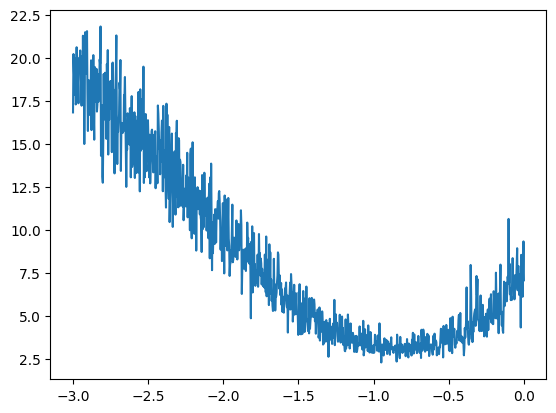

In [114]:
plt.plot(lri, lossi)

In [103]:
# checking loss on entire dataset
emb = C[X]
l1 = torch.tanh(emb.view(-1, char_dim*block_size) @ W1 + b1)
logits = l1 @ W2 + b2
loss = F.cross_entropy(logits, Y)
print(f'{loss=}')

loss=tensor(3.3561, grad_fn=<NllLossBackward0>)
